#### Executing this notebook depends on the Delta tables from project 1 being saved in DBFS!
In project 1, make sure to run chapters 1, 2, 3 fully to save the Delta tables.

#### Also make sure you have GraphFrames installed on the cluster!
https://spark-packages.org/package/graphframes/graphframes

(Choose the correct versions of Spark and Scala!)

In [0]:
# For visualization, also install NetworkX.
# Installing NetworkX via jar didn't work for me so here I install it via pip.
%pip install networkx

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pyspark.sql.functions as F
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import graphframes as gf
import networkx as nx

spark.conf.set("spark.sql.shuffle.partitions", sc.defaultParallelism) #shuffle partitions for faster processing of graph algorithms

In [0]:
dblp_df = spark.read.load('dbfs:/user/dblpv13/dblp_full')
author_df = spark.read.load('dbfs:/user/dblpv13/authors_full')
org_df = spark.read.load('dbfs:/user/dblpv13/orgs_full')
venue_df = spark.read.load('dbfs:/user/dblpv13/venues_full')

logger.info(f'Read table row counts:\n\tDBLP fact table: {dblp_df.count()}\n\tAuthor table: {author_df.count()}\n\tVenue table: {venue_df.count()}\n\tOrganization table: {org_df.count()}')

INFO:py4j.java_gateway:Received command c on object id p0
INFO:__main__:Read table row counts:
	DBLP fact table: 1535623
	Author table: 1616238
	Venue table: 27232
	Organization table: 15321


In [0]:
def lim_print(df, lim):
    display(df.limit(lim))

### Vertices
* Needs to contain column **id**

To each DF, add the vertex type. We will have 4 types of vertices: publications, authors, organizations, venues.

In [0]:
# Add type to each df and rename column 'ID' to 'id'.
dblp_df = dblp_df.withColumn('Type', F.lit('publication')).withColumnRenamed('ID', 'id')
author_df = author_df.withColumn('Type', F.lit('author')).withColumnRenamed('ID', 'id')
org_df = org_df.withColumn('Type', F.lit('org')).withColumnRenamed('ID', 'id')
venue_df = venue_df.withColumn('Type', F.lit('venue')).withColumnRenamed('ID', 'id')

# Union the relevant columns of each df into a single df.
_vertices = (dblp_df
            .select('id', 'Type')
            .union(author_df
                   .select('id', 'Type'))
            .union(org_df
                   .select('id', 'Type'))
            .union(venue_df
                   .select('id', 'Type')))

In [0]:
lim_print(_vertices, 10)

id,Type
53e99784b7602d9701f3f5fe,publication
53e99792b7602d9701f5af35,publication
53e99792b7602d9701f5b0ed,publication
53e99792b7602d9701f5b119,publication
53e99792b7602d9701f5b140,publication
53e99792b7602d9701f5b19a,publication
53e99792b7602d9701f5b1ba,publication
53e99792b7602d9701f5b1e7,publication
53e99792b7602d9701f5b2b3,publication
53e99792b7602d9701f5b2bc,publication


### Edges
* Need to contain columns **src** and **dst**

We will have 4 kinds of relationships: 
* isAuthorOf (Author -> Publication)
* cites (Publication -> Publication)
* hosts (Venue -> Publication)
* worksFor (Author -> Organization)

#### isAuthorOf

In [0]:
# Source is exploded dblp.Authors
# Destination is dblp.id
isAuthorOf_edges = (dblp_df
                    .withColumn('src', F.explode(dblp_df.Authors))
                    .withColumnRenamed('id', 'dst')
                    .withColumn('Type', F.lit('isAuthorOf'))
                    .select('src', 'Type', 'dst'))

In [0]:
lim_print(isAuthorOf_edges, 10)

src,Type,dst
562d81cf45cedb3398e36c2c,isAuthorOf,5571f5d524014945536058bd
562d81cf45cedb3398e36c2f,isAuthorOf,5571f5d524014945536058bd
562d81d545cedb3398e36e02,isAuthorOf,5571f7ca24014945536058f7
563082cc45cedb3399a92aed,isAuthorOf,5571f7ca24014945536058f7
562d808045cedb3398e3344b,isAuthorOf,55703e822401b4b38c239df9
562d808045cedb3398e3344e,isAuthorOf,55703e822401b4b38c239df9
562d808045cedb3398e33451,isAuthorOf,55703e822401b4b38c239df9
53f434b7dabfaec09f16db9c,isAuthorOf,55703e822401b4b38c239df9
562d807345cedb3398e33037,isAuthorOf,55703bbd2401b4b38c239d73
562d807345cedb3398e3303a,isAuthorOf,55703bbd2401b4b38c239d73


#### cites

In [0]:
# Source is dblp.id
# Destination is exploded dblp.References
cites_edges = (dblp_df
               .withColumn('dst', F.explode(dblp_df.References))
               .withColumnRenamed('id', 'src')
               .withColumn('Type', F.lit('cites'))
               .select('src', 'Type', 'dst'))

#### hosts

In [0]:
# Source is dblp.Venue
# Destination is dblp.id
hosts_edges = (dblp_df
               .withColumnRenamed('id', 'dst')
               .withColumnRenamed('Venue', 'src')
               .withColumn('Type', F.lit('hosts'))
               .select('src', 'Type', 'dst'))

#### worksFor

In [0]:
# Source is the first author of each publication
# Destination is the org of that publication
worksFor_edges = (dblp_df
                  .withColumn('src', dblp_df.Authors.getItem(0))
                  .withColumnRenamed('Org', 'dst')
                  .withColumn('Type', F.lit('worksFor'))
                  .select('src', 'Type', 'dst'))

Let's combine the edges into one DF.

In [0]:
_edges = isAuthorOf_edges.union(cites_edges).union(hosts_edges).union(worksFor_edges)

In [0]:
lim_print(_edges, 10)

src,Type,dst
562d81cf45cedb3398e36c2c,isAuthorOf,5571f5d524014945536058bd
562d81cf45cedb3398e36c2f,isAuthorOf,5571f5d524014945536058bd
562d81d545cedb3398e36e02,isAuthorOf,5571f7ca24014945536058f7
563082cc45cedb3399a92aed,isAuthorOf,5571f7ca24014945536058f7
562d808045cedb3398e3344b,isAuthorOf,55703e822401b4b38c239df9
562d808045cedb3398e3344e,isAuthorOf,55703e822401b4b38c239df9
562d808045cedb3398e33451,isAuthorOf,55703e822401b4b38c239df9
53f434b7dabfaec09f16db9c,isAuthorOf,55703e822401b4b38c239df9
562d807345cedb3398e33037,isAuthorOf,55703bbd2401b4b38c239d73
562d807345cedb3398e3303a,isAuthorOf,55703bbd2401b4b38c239d73


### Build the GraphFrame

In [0]:
_graph = gf.GraphFrame(_vertices, _edges)

### Queries (Motif-finding)

**Legend for visualizations:**
* Red - publications
* Purple - venues
* Blue - authors
* Green - organizations
* Orange - special vertex (vertex that the query started from)

Co-authorship network of an author. Given an Author's id, find all of the authors they have published some work with.

TODO: color nodes according to schema.

In [0]:
result = (_graph
          .filterEdges('Type = "isAuthorOf"')
          .find('(a)-[e1]->(b); (c)-[e2]->(b)')
          .filter('a.id == "542a67e9dabfae646d55d787" and c.id != a.id')) # Put the author ID here

In [0]:
display(net)

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


a,e1,b,c,e2
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9a87fb7602d97031cf1e4)","List(53e9a87fb7602d97031cf1e4, publication)","List(53f448a0dabfaeecd69b5b38, author)","List(53f448a0dabfaeecd69b5b38, isAuthorOf, 53e9a87fb7602d97031cf1e4)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9b689b7602d97041f6e89)","List(53e9b689b7602d97041f6e89, publication)","List(53f45b1ddabfaedf4361d054, author)","List(53f45b1ddabfaedf4361d054, isAuthorOf, 53e9b689b7602d97041f6e89)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e99beab7602d970249323b)","List(53e99beab7602d970249323b, publication)","List(53f45b1ddabfaedf4361d054, author)","List(53f45b1ddabfaedf4361d054, isAuthorOf, 53e99beab7602d970249323b)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e99f48b7602d970281b436)","List(53e99f48b7602d970281b436, publication)","List(5603e29745cedb3396281785, author)","List(5603e29745cedb3396281785, isAuthorOf, 53e99f48b7602d970281b436)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9a627b7602d9702f5642c)","List(53e9a627b7602d9702f5642c, publication)","List(53f43a65dabfaec09f1a2d3b, author)","List(53f43a65dabfaec09f1a2d3b, isAuthorOf, 53e9a627b7602d9702f5642c)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9ba05b7602d97046071c9)","List(53e9ba05b7602d97046071c9, publication)","List(53f44c5adabfaedd74e06816, author)","List(53f44c5adabfaedd74e06816, isAuthorOf, 53e9ba05b7602d97046071c9)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e99b6ab7602d970240db48)","List(53e99b6ab7602d970240db48, publication)","List(53f7d9e5dabfae9060aefe2d, author)","List(53f7d9e5dabfae9060aefe2d, isAuthorOf, 53e99b6ab7602d970240db48)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9b689b7602d97041f6e89)","List(53e9b689b7602d97041f6e89, publication)","List(53f7d9e5dabfae9060aefe2d, author)","List(53f7d9e5dabfae9060aefe2d, isAuthorOf, 53e9b689b7602d97041f6e89)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9aba4b7602d9703551541)","List(53e9aba4b7602d9703551541, publication)","List(53f7d9e5dabfae9060aefe2d, author)","List(53f7d9e5dabfae9060aefe2d, isAuthorOf, 53e9aba4b7602d9703551541)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e99ea0b7602d9702767040)","List(53e99ea0b7602d9702767040, publication)","List(53f7d9e5dabfae9060aefe2d, author)","List(53f7d9e5dabfae9060aefe2d, isAuthorOf, 53e99ea0b7602d9702767040)"


In [0]:
# Functions for drawing nice graphs.

def find_color(id2Type, color_map, special_vertex, v):
    if (special_vertex is not None) and v == special_vertex:
        return color_map['special']
    
    type = id2Type[id2Type['id'] == v]['Type'].values[0]
    
    return color_map[type]

def add_edges(g, df, edge_colnames):
    df_pandas = df.toPandas()

    # Iterate over the columns and rows.
    # From each row, add an edge with the src and dst.
    for colname in edge_colnames:
        for row in df_pandas[colname]:
            src, dst = row['src'], row['dst']
            g.add_edge(row['src'], row['dst'])
    
    

# Based on https://stackoverflow.com/a/57784880
def plot_graph(df, edge_colnames, special_vertex = None):
    """ Inputs: 
            df - DataFrame of the graph you want to plot 
            edge_colnames - iterable of df column names that hold the edges of the graph
            special_vertex - id of the vertex we want to color yellow (special color)
    """
    g = nx.DiGraph()
    
    add_edges(g, df, edge_colnames)
       
    # Get only the vertices columns from the df.
    vertices = df.select([c for c in df.columns if c not in edge_colnames])
    
    id2Type = (vertices
               .withColumn('collected', F.array(vertices.columns))
               .withColumn('exploded', F.explode(F.col('collected')))
               .withColumn('id', F.col('exploded.id'))
               .withColumn('Type', F.col('exploded.Type'))
               .select('id', 'Type')
               .distinct()).toPandas()
    
    color_map = {'publication': '#f54040', 
                 'venue': '#d40ee6', 
                 'org': '#77e637', 
                 'special': '#ffc61c', 
                 'author': '#1da6f5'}
            
    plt.figure(figsize=(13, 13))  
    nx.draw(g, node_color = [find_color(id2Type, color_map, special_vertex, v) for v in g])

INFO:py4j.java_gateway:Received command  on object id 
INFO:py4j.java_gateway:Closing down callback connection


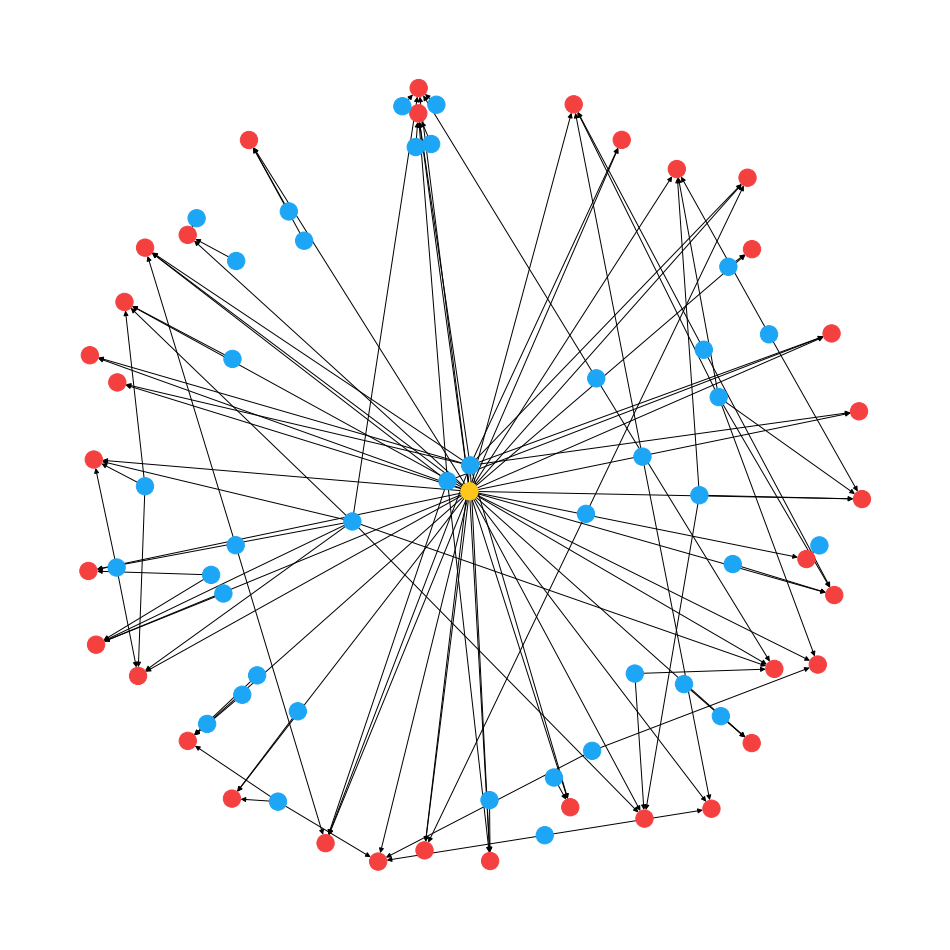

In [0]:
plot_graph(result, ('e1', 'e2'), '542a67e9dabfae646d55d787')

Given an org ID, which authors work for that org. - Martin

Given a publication ID, what organizations have the authors of this publication worked for. - Peep

In [0]:
net = (_graph
       .filterEdges('Type = "isAuthorOf" | Type = worksFor')
       #.find('(a)-[e1]->(b); (c)-[e2]->(b)')
       #.filter('a.id == "542a67e9dabfae646d55d787" and c.id != a.id')) # Put the author ID here
      )

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1509400414693873> in <module>
----> 1 net = (_graph
      2        .filterEdges('Type = "isAuthorOf" | Type = worksFor')
      3        #.find('(a)-[e1]->(b); (c)-[e2]->(b)')
      4        #.filter('a.id == "542a67e9dabfae646d55d787" and c.id != a.id')) # Put the author ID here
      5       )

NameError: name '_graph' is not defined

Given a Venue ID, find all authors who have been hosted by that venue. - Martin

### Analytics

PageRank - P

connected components - M

bfs between two publications: returns a path from one node to another. To find out if a publication indirectly references another publication. -P

in-degrees of a publication. How many authors this publication has. -M

out-degrees of a venue. How many publications has a venue hosted. -P

traingle count -M

triplets -P